In [1]:
!pip install -U datasets #>=1.18.3
!pip install -U transformers #==4.17.0
!pip install -U evaluate
!pip install -U librosa
!pip install -U seaborn
!pip install -U jiwer

In [123]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

WANDB_KEY = user_secrets.get_secret("wandb_key")

In [124]:
from evaluate import load
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Processor, AutoModel
import torch
import torch.nn as nn
import os
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from typing import List, Dict, Optional, Any, Union
import matplotlib.pyplot as plt
import json
from datasets import Dataset, DatasetDict, Audio, load_dataset
from tqdm.auto import tqdm
import pandas as pd
import torchaudio
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2PhonemeCTCTokenizer
from transformers import AutoFeatureExtractor
from transformers import Wav2Vec2Processor
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import IPython.display as ipd
import random
from transformers import TrainingArguments, Trainer
import wandb

# Dataset

## Let's load dataset
Our split strategy - https://github.com/te1ord/PhonemeRecognition/blob/main/notebooks/cv-split.ipynb

We did group split by dialect column as our test appears not to have dialects which are present in train set, so we create validation with dialect, which is not present during training.

It also appeared to be group split by speaker_id as each speaker has only one dialect.

In [126]:
DATA_PATH = '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/'
DATA_SPLIT = '/kaggle/input/timit-data-split/TIMIT_DATA_SPLIT.json'
SSL_DATA_PATH = '/kaggle/input/timit-ssl-features'

In [127]:
with open(DATA_SPLIT, "r") as f:
    dataset = json.load(f)

dataset.keys()

dict_keys(['train', 'valid', 'test'])

# Preprocessing
Some processing/eda functions from

https://www.kaggle.com/code/vladimirsydor/phoneme-recognition-with-wav2vec2#Build-Character-Set

## Process into HuggingFace Dataset Format

In [128]:
def convert_to_feature_dict(data_dict):
    # convert each feature into an array instead
    audio_files = []
    word_files = []
    phonetic_files = []
    for key, value in data_dict.items():
        audio_files.append(value['audio_file'])
        word_files.append(value['word_file'])
        phonetic_files.append(value['phonetic_file'])
    
    return {
        'audio_file': audio_files,
        'word_file': word_files,
        'phonetic_file': phonetic_files
    }

In [129]:
train = convert_to_feature_dict(dataset['train'])
valid = convert_to_feature_dict(dataset['valid'])
test  = convert_to_feature_dict(dataset['test'])

In [130]:
train_dataset = Dataset.from_dict(train)
valid_dataset = Dataset.from_dict(valid)
test_dataset = Dataset.from_dict(test)

In [131]:
print(train_dataset)

Dataset({
    features: ['audio_file', 'word_file', 'phonetic_file'],
    num_rows: 1440
})


## Read files for phonetics

In [132]:
def read_text_file(filepath):
    with open(filepath) as f:
        tokens = [line.split()[-1] for line in f]
        return " ".join(tokens)
    
def prepare_text_data(item):
    item['text'] = read_text_file(item['word_file'])
    item['phonetic'] = read_text_file(item['phonetic_file'])
    return item

In [133]:
train_dataset = (train_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
valid_dataset = (valid_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))
test_dataset  = (test_dataset
                 .map(prepare_text_data)
                 .remove_columns(["word_file", "phonetic_file"]))

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

## Normalize the Phonetics

As we can see the result below, there are *61* phones. However, we don't need to use all of them. "tcl", for example, is just a pause where there is a "t". So, let's keep it up and simplify them a bit.

In [134]:
train_dataset

Dataset({
    features: ['audio_file', 'text', 'phonetic'],
    num_rows: 1440
})

In [135]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
print("num of train phones:\t", len(set(train_phonetics)))

num of train phones:	 61


In [136]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#' 
}

def convert_phon61_to_phon39(sentence):
    tokens = [phon61_map39[x] for x in sentence.split()]
    return " ".join(tokens)

def normalize_phones(item):
    item['phonetic'] = convert_phon61_to_phon39(item['phonetic'])
    return item

In [137]:
train_dataset = train_dataset.map(normalize_phones)
valid_dataset = valid_dataset.map(normalize_phones)
test_dataset = test_dataset.map(normalize_phones)

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [138]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
valid_phonetics = [phone for x in valid_dataset for phone in x['phonetic'].split()]
test_phonetics = [phone for x in test_dataset for phone in x['phonetic'].split()]

print("num of train phones:\t", len(set(train_phonetics)))
print("num of valid phones:\t", len(set(valid_phonetics)))
print("num of test phones:\t", len(set(test_phonetics)))

num of train phones:	 39
num of valid phones:	 39
num of test phones:	 39


## Phonetic Distribution
Let's check the distribution of each phone across all three test set. Note that we don't do simple counting. Instead, for each phoneme, we show the ratio of that phoneme relative to that specific set. On test set, obviously, the count of each phoneme is less than the train, but the ratio should be similar to the training set.

In [139]:
phone_vocabs = set(train_phonetics)
phone_vocabs.remove('h#')
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    # eliminate h# for visualization purposes
    return [phone_counts[phone] for phone in phone_vocabs] 

In [140]:
train_phone_counts = count_frequency(train_phonetics)
valid_phone_counts = count_frequency(valid_phonetics)
test_phone_counts  = count_frequency(test_phonetics)

In [141]:
train_phone_ratio = [count / sum(train_phone_counts) for count in train_phone_counts]
valid_phone_ratio = [count / sum(valid_phone_counts) for count in valid_phone_counts]
test_phone_ratio  = [count / sum(test_phone_counts) for count in test_phone_counts]

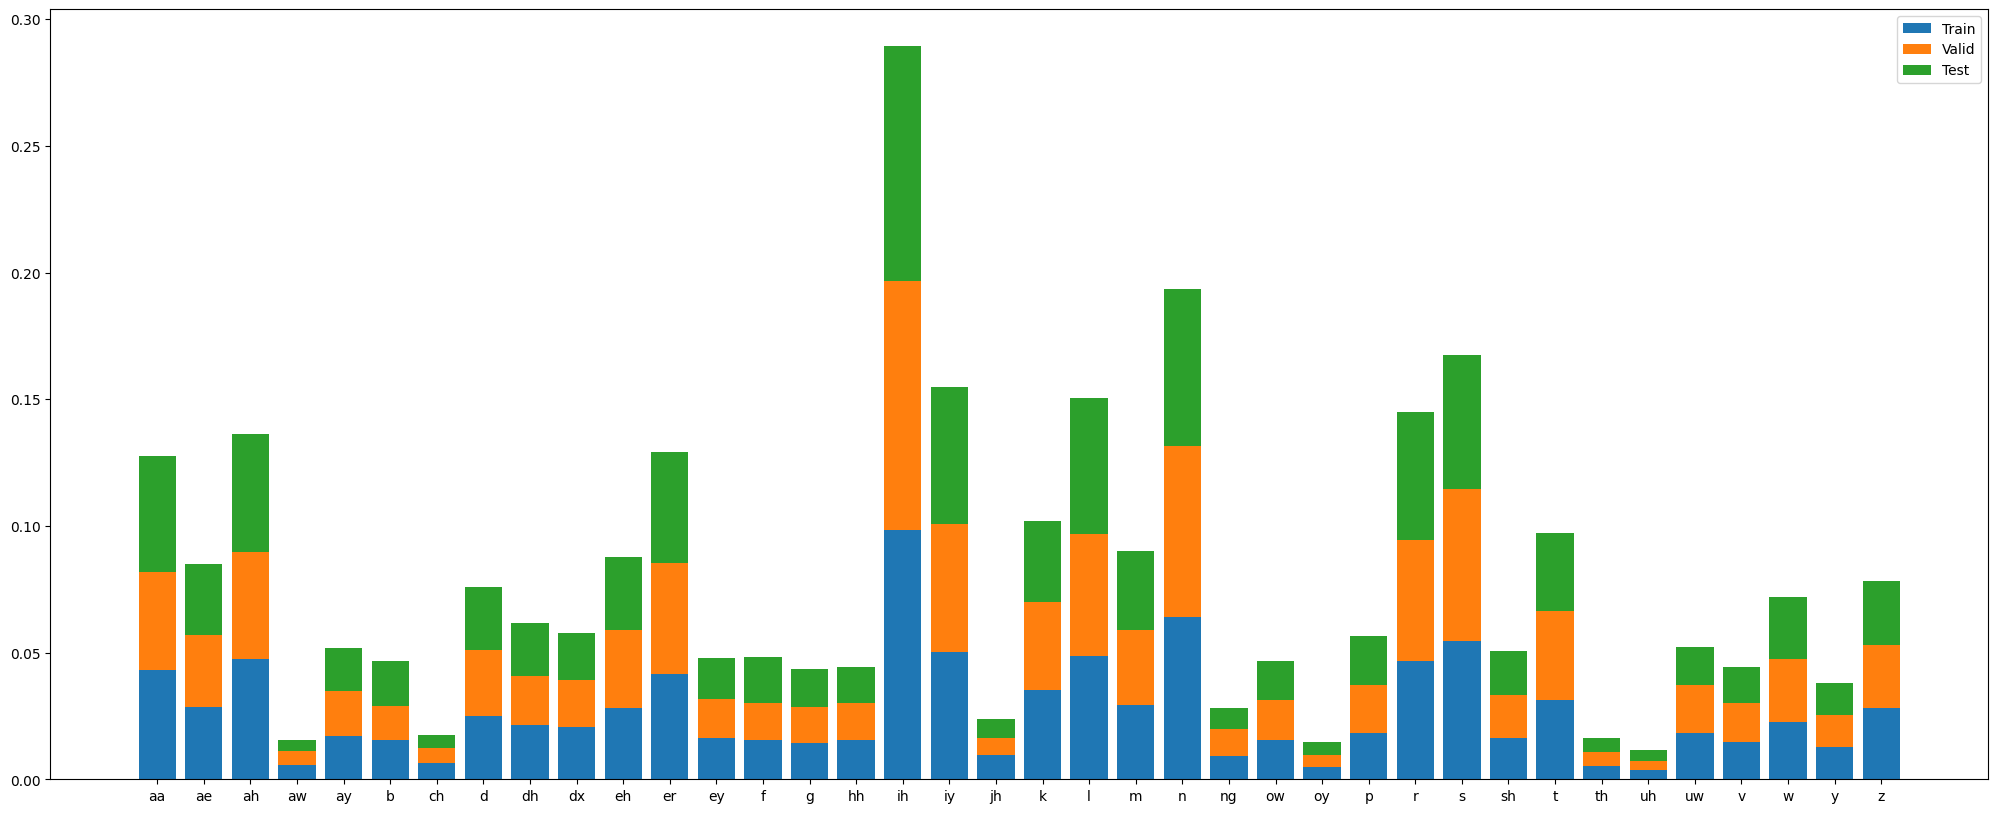

In [ ]:

plt.figure(figsize=(25,10))

plt.bar(phone_vocabs, train_phone_ratio, label="Train")
plt.bar(phone_vocabs, valid_phone_ratio, bottom=train_phone_ratio, label="Valid")
plt.bar(phone_vocabs, test_phone_ratio, bottom=[(x+y) for x,y in zip(train_phone_ratio, valid_phone_ratio)], label="Test")

plt.legend()

plt.show()

## Load Audio File

In [143]:
train_dataset = (train_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
valid_dataset = (valid_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
test_dataset = (test_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))

In [144]:
train_dataset[0]

{'audio': {'path': '/kaggle/input/darpa-timit-acousticphonetic-continuous-speech/data/TRAIN/DR3/FALK0/SA1.WAV',
  'array': array([-9.15527344e-05,  2.74658203e-04,  1.22070312e-04, ...,
         -9.15527344e-05, -2.74658203e-04,  1.22070312e-04]),
  'sampling_rate': 16000},
 'text': 'she had your dark suit in greasy wash water all year',
 'phonetic': 'h# sh iy hh eh h# d y er h# d aa r h# k s uw h# h# ih n h# g r iy z iy w aa sh h# w aa dx er h# aa l y ih er h#'}

In [145]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(train_dataset)-1)

print("Text:", train_dataset[rand_int]["text"])
print("Phonetics:", train_dataset[rand_int]["phonetic"])
print("Input array shape:", train_dataset[rand_int]["audio"]["array"].shape)
print("Sampling rate:", train_dataset[rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=train_dataset[rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: just drop notices in any suggestion box
Phonetics: h# jh ah s h# d r aa h# n ow dx ih s ih z ih n iy s ah h# jh eh sh n h# b aa h# k s h#
Input array shape: (38605,)
Sampling rate: 16000


## Build Character Set

In [146]:
vocab_train = list(set(train_phonetics)) #+ [' ']
vocab_valid = list(set(valid_phonetics)) #+ [' ']
vocab_test  = list(set(test_phonetics)) #+ [' ']

In [147]:
vocab_list = list(set(vocab_train + vocab_valid + vocab_test))
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}

print(vocab_dict)

{'aa': 0, 'ae': 1, 'ah': 2, 'aw': 3, 'ay': 4, 'b': 5, 'ch': 6, 'd': 7, 'dh': 8, 'dx': 9, 'eh': 10, 'er': 11, 'ey': 12, 'f': 13, 'g': 14, 'h#': 15, 'hh': 16, 'ih': 17, 'iy': 18, 'jh': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'ng': 24, 'ow': 25, 'oy': 26, 'p': 27, 'r': 28, 's': 29, 'sh': 30, 't': 31, 'th': 32, 'uh': 33, 'uw': 34, 'v': 35, 'w': 36, 'y': 37, 'z': 38}


In [149]:
# save vocab.json

with open('/kaggle/working/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

# Dataset

## Default Dataset

In [153]:
# --------------------------------
# 1. Data Processing Components
# --------------------------------

def create_processor(ssl_model_name, tokenizer_dir):

    tokenizer = Wav2Vec2PhonemeCTCTokenizer.from_pretrained(
        "/kaggle/working/",
        unk_token="[UNK]",
        pad_token="[PAD]",
        do_phonemize=False
    )
    
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
        ssl_model_name,
        feature_size=1, 
        sampling_rate=16000, 
        padding_value=0.0, 
        do_normalize=True, 
        return_attention_mask=True
    )
    
    processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)
    
    return processor

def prepare_dataset(batch, processor):
    """Prepare a dataset batch with the given processor"""
    audio = batch["audio"]
    
    batch["input_values"] = processor(audio["array"], 
                                    sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["phonetic"]).input_ids
    return batch

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels

        return batch

## SSL Features Dataset

Class which is designed to dump features from different hidden states of given SSL model.

In [155]:
class SSLFeatureDumper:
    def __init__(
        self,
        model,
        data_collator,
        device: str = None,
    ):
        """
        Args:
            model: Pretrained SSL model (e.g. WavLMModel).
            data_collator: DataCollator instance for batching raw audio.
            device: Device to run inference on, e.g., "cuda" or "cpu". Defaults to GPU if available.
        """
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.model.eval()
        self.collator = data_collator

    def _create_data_loader(self, dataset, batch_size, num_workers):
        """Create a DataLoader for the dataset."""
        return DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            collate_fn=self.collator,
            pin_memory=True,
        )

    
    def _initialize_storage(self, layer_indexes):
        """Initialize storage dictionaries for features and metadata."""
        # Prepare storage for each layer's features
        layer_data = {
            layer_idx: {
                "ssl_features": [],
                "input_lengths": [],
                "output_lengths": [],
            }
            for layer_idx in layer_indexes
        }
        
        # Storage for labels (only stored once)
        labels_data = []
        
        return layer_data, labels_data

        
    def _process_batch(self, batch):
        """Process a single batch through the model."""
        # Move batch to device (excluding labels for memory efficiency)
        input_values = batch["input_values"].to(self.device)
        attention_mask = batch.get("attention_mask", None)
        if attention_mask is not None:
            attention_mask = attention_mask.to(self.device)
        
        # Get model outputs (including all hidden states)
        outputs = self.model(
            input_values,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True,
        )


        attention_mask = (
                attention_mask if attention_mask is not None else torch.ones_like(input_values, dtype=torch.long)
            )
        
        input_lengths = attention_mask.sum(-1)
        output_lengths = self._get_feat_extract_output_lengths(input_lengths).to(torch.long)
            
        return outputs, input_values, input_lengths, output_lengths

    def _get_feat_extract_output_lengths(self, input_lengths):
        """Computes the output length of the convolutional layers"""

        def _conv_out_length(input_length, kernel_size, stride):
            # 1D convolutional layer output length formula taken
            # from https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
            return torch.div(input_length - kernel_size, stride, rounding_mode="floor") + 1

        for kernel_size, stride in zip(self.model.config.conv_kernel, self.model.config.conv_stride):
            input_lengths = _conv_out_length(input_lengths, kernel_size, stride)

        return input_lengths

    
    def _extract_features(self, outputs, batch_idx, length, layer_idx):
        """Extract features for a specific example and layer."""
        if layer_idx == -1:
            return outputs.last_hidden_state[batch_idx, :length].cpu().numpy()
        else:
            return outputs.hidden_states[layer_idx][batch_idx, :length].cpu().numpy()
    
    def _process_labels(self, batch, batch_idx):
        """Process labels for a specific example."""
        label_tensor = batch["labels"][batch_idx].cpu()
        return [token for token in label_tensor.tolist() if token >= 0]
    
    def _save_features(self, layer_data, layer_indexes, output_dir, filename_prefix):
        """Save extracted features to disk and return the saved data."""
        saved_data = []
        for layer_idx in layer_indexes:
            # Create a descriptive name for the layer
            if layer_idx == -1:
                layer_name = "final"
            else:
                layer_name = f"layer{layer_idx}"
            
            # Create the output path
            output_file = os.path.join(output_dir, f"{filename_prefix}_{layer_name}.pt")
            
            # Save to file
            torch.save(layer_data[layer_idx], output_file)
            saved_data.append(layer_data[layer_idx])
            
            # Print statistics
            self._print_layer_stats(layer_data[layer_idx], layer_name, output_file)
            
        return saved_data
    
    def _print_layer_stats(self, layer_data, layer_name, output_file):
        """Print statistics about the extracted features."""
        n_examples = len(layer_data["ssl_features"])
        if n_examples > 0:
            feature_dim = layer_data["ssl_features"][0].shape[-1]
            avg_length = np.mean(layer_data["output_lengths"])
            print(f"Layer {layer_name}: Saved {n_examples} examples to {output_file}")
            print(f"  Feature dimension: {feature_dim}, Average out length: {avg_length:.2f}")
    
    def dump_features(
        self,
        dataset,
        output_dir: str,
        filename_prefix: str,
        layer_indexes: Union[int, List[int]] = -1,
        batch_size: int = 8,
        num_workers: int = 4,
    ):
        """
        Extracts features from one or multiple SSL layers and saves them to disk.
        
        Args:
            dataset: A torch Dataset returning dicts with input_values and optional labels.
            output_dir: Directory to save feature files.
            filename_prefix: Prefix for each output file (e.g. "train" yields "train_layer12.pt").
            layer_indexes: Layer index or list of layer indices to extract features from.
                          Use -1 for the final layer's output.
            batch_size: Batch size for the DataLoader.
            num_workers: Number of workers for the DataLoader.
            
        Returns:
            Dict or List[Dict]: The extracted data, either a single dict or list of dicts (one per layer)
        """
        os.makedirs(output_dir, exist_ok=True)
        
        # Convert single layer_index to list for unified processing
        if isinstance(layer_indexes, int):
            layer_indexes = [layer_indexes]
            
        # Create data loader
        loader = self._create_data_loader(dataset, batch_size, num_workers)
        
        # Initialize storage
        layer_data, labels_data = self._initialize_storage(layer_indexes)
        
        # Flag to check if dataset has labels
        has_labels = False
        
        # Process all batches
        with torch.no_grad():
            for batch in tqdm(loader, desc=f"Processing features for {len(layer_indexes)} layer(s)"):
                # Check for labels
                if not has_labels and "labels" in batch:
                    has_labels = True
                
                # Process batch through model
                outputs, input_values, input_lengths, output_lengths = self._process_batch(batch)
                
                # Process each example in the batch
                for i in range(input_values.size(0)):
                    input_length = int(input_lengths[i])
                    output_length = int(output_lengths[i])
                    
                    # Process labels if available
                    if has_labels:
                        labels_data.append(self._process_labels(batch, i))
                    
                    # Extract features for each requested layer
                    for layer_idx in layer_indexes:
                        feats = self._extract_features(outputs, i, output_length, layer_idx)
                        
                        # Store this example's data
                        layer_data[layer_idx]["ssl_features"].append(feats)
                        layer_data[layer_idx]["input_lengths"].append(input_length)
                        layer_data[layer_idx]["output_lengths"].append(output_length)
        
        # Add labels to all layers if present
        if has_labels:
            for layer_idx in layer_indexes:
                layer_data[layer_idx]["labels"] = labels_data
        
        # Save features to disk
        saved_data = self._save_features(layer_data, layer_indexes, output_dir, filename_prefix)
        
        # Return single dict for single layer or list for multiple layers
        if len(layer_indexes) == 1:
            return saved_data[0]
        return saved_data

Dataset class which loads dumped features and prepares them for training.

In [156]:
class SSLFeatureDataset(Dataset):
    """Dataset for loading pre-extracted SSL features for use with HuggingFace Trainer"""
    
    def __init__(self, features_file: str, max_length: Optional[int] = None, convert_to_tensor: bool = False):
        """
        Args:
            features_file: Path to the file with pre-extracted features
            max_length: Maximum sequence length (will clip longer sequences)
            convert_to_tensor: Whether to convert features to PyTorch tensors during loading
        """
        self._data = torch.load(features_file)
        self.max_length = max_length
        self.convert_to_tensor = convert_to_tensor
        
        # Verify data integrity
        assert len(self._data["ssl_features"]) > 0, "Empty features dataset"
            
        print(f"Loaded {len(self._data['ssl_features'])} examples from {features_file}")
        if len(self._data['ssl_features']) > 0:
            print(f"Feature dimension: {self._data['ssl_features'][0].shape[-1]}")
            print(f"Feature type: {type(self._data['ssl_features'][0])}")
            
    def __len__(self):
        return len(self._data["ssl_features"])
    
    def __getitem__(self, idx):
        features = self._data["ssl_features"][idx]
        
        # Clip if needed
        if self.max_length and features.shape[0] > self.max_length:
            features = features[:self.max_length]
            
        # Convert to tensor if requested and needed
        if self.convert_to_tensor and isinstance(features, np.ndarray):
            features = torch.from_numpy(features).float()
        
        # Create attention mask (1 for non-padded positions)
        attention_mask = torch.ones(features.shape[0], dtype=torch.long)
        
        # Build the item dictionary
        item = {
            "input_ids": features,  # Renamed from "features" for clarity
            "attention_mask": attention_mask,
        }
        
        # Add labels if available
        if "labels" in self._data and self._data["labels"][idx] is not None:
            labels = self._data["labels"][idx]
            if self.convert_to_tensor and isinstance(labels, np.ndarray):
                labels = torch.from_numpy(labels).long()
            item["labels"] = labels
            
        return item


@dataclass
class FeatureCollatorCTCForTrainer:
    """
    Collator for pre-extracted SSL features to be used with CTC loss in HuggingFace Trainer
    Implemented as a dataclass for compatibility with Trainer
    """
    pad_token_id: int = -100
    feature_dim: Optional[int] = None
    
    def __call__(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        # Get the features from each item
        features = [item["input_ids"] for item in batch]
        
        # Get feature dimension if not provided
        if self.feature_dim is None:
            self.feature_dim = features[0].shape[-1]
            
        # Get max sequence length in this batch
        max_length = max(feat.shape[0] for feat in features)
        
        # Create padded feature tensor and attention mask
        batch_size = len(features)
        padded_features = torch.zeros((batch_size, max_length, self.feature_dim))
        attention_mask = torch.zeros((batch_size, max_length), dtype=torch.long)
        
        # Fill in the data - convert NumPy arrays to PyTorch tensors
        for i, feat in enumerate(features):
            seq_len = feat.shape[0]
            # Convert numpy array to torch tensor if needed
            if isinstance(feat, np.ndarray):
                feat_tensor = torch.from_numpy(feat).float()
            else:
                feat_tensor = feat.float() if feat.dtype != torch.float32 else feat
                
            padded_features[i, :seq_len] = feat_tensor
            attention_mask[i, :seq_len] = 1
            
        # Process labels if available
        result = {
            "input_values": padded_features,  # HF often expects 'input_features' for audio
            "attention_mask": attention_mask,
        }
        
        # Add labels if provided
        if "labels" in batch[0] and batch[0]["labels"] is not None:
            labels = [item["labels"] for item in batch]
            max_label_len = max(len(label) for label in labels)
            
            padded_labels = torch.full(
                (batch_size, max_label_len), 
                self.pad_token_id, 
                dtype=torch.long
            )
            
            for i, label in enumerate(labels):
                if len(label) > 0:  # Skip empty labels
                    # Convert to tensor if it's a numpy array
                    if isinstance(label, np.ndarray):
                        label_tensor = torch.from_numpy(label).long()
                    elif isinstance(label, list):
                        label_tensor = torch.tensor(label, dtype=torch.long)
                    else:
                        label_tensor = label.long() if label.dtype != torch.int64 else label
                        
                    padded_labels[i, :len(label)] = label_tensor
                    
            result["labels"] = padded_labels
            
        return result

In [ ]:
# Example usage

model, data_collator = []
dumper = SSLFeatureDumper(model, data_collator)


dumper.dump_features(
    dataset=train_dataset,
    output_dir="train/",
    filename_prefix="train",
    layer_indexes=[11, 15, 19, -1]
)

dumper.dump_features(
    dataset=valid_dataset,
    output_dir="valid/",
    filename_prefix="valid",
    layer_indexes=[11, 15, 19, -1]
)

dumper.dump_features(
    dataset=test_dataset,
    output_dir="test/",
    filename_prefix="test",
    layer_indexes=[11, 15, 19, -1]
)

## Extracted Dataset
dataset link - https://www.kaggle.com/datasets/nuinashco/timit-ssl-features

detailed code - https://github.com/te1ord/PhonemeRecognition/blob/main/notebooks/ssl_features_dump.ipynb

# Model

Universal class which works in 3 modes:

1. heads fine-tuning on dumped features
2. fine-tuning of whole model (along with custom heads and ssl)
3. fine-tuning of custom heads on features extracted on-the-fly

In [108]:
###########################################################
### FULL CUSTOM
###########################################################

# ----------------------------
# Custom Wrapper Modules
# ----------------------------

data_collator
class GRUWrapper(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=True, batch_first=True):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=batch_first, bidirectional=bidirectional)
    
    def forward(self, x):
        out, _ = self.gru(x)
        return out

class AttentionWrapper(nn.Module):
    def __init__(self, hidden_size, num_heads=8, dropout=0.0, batch_first=True):
        super().__init__()
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=num_heads, dropout=dropout, batch_first=batch_first)
        self.layer_norm = nn.LayerNorm(hidden_size)
    
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        out = self.layer_norm(x + attn_output)
        return out

# ----------------------------
# SSL Model with Custom Head
# ----------------------------

class SSLModelWithCustomHead(nn.Module):
    def __init__(self, ssl_model_name, mode, head_type, vocab_size, processor, hidden_size=None, dropout=0.1):
        super().__init__()
        self.mode = mode

        if self.mode != 'ssl_ft':
            self.ssl_model = AutoModel.from_pretrained(ssl_model_name)

            if hidden_size is None:
                self.hidden_size = self.ssl_model.config.hidden_size
            else:
                self.hidden_size = hidden_size
        else:
            self.hidden_size = 1024 # dim of extracted feature embeddings from hidden states


        self.processor=processor            
        self.dropout = nn.Dropout(dropout)
        self.vocab_size = vocab_size
        self.head_type = head_type
        
        if head_type == "linear":
            self.head = nn.Sequential(
                nn.Linear(self.hidden_size, vocab_size)
            )
        elif head_type == "mlp":
            self.head = nn.Sequential(
                nn.Linear(self.hidden_size, self.hidden_size),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(self.hidden_size, vocab_size)
            )
        elif head_type == "gru":
            self.head = nn.Sequential(
                GRUWrapper(self.hidden_size, self.hidden_size, bidirectional=True, batch_first=True),
                nn.Linear(self.hidden_size * 2, vocab_size)
            )
        elif head_type == "conv":
            self.head = nn.Sequential(
                nn.Conv1d(self.hidden_size, self.hidden_size, kernel_size=3, padding=1),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Conv1d(self.hidden_size, vocab_size, kernel_size=1)
            )
        elif head_type == "attention":
            self.head = nn.Sequential(
                AttentionWrapper(self.hidden_size, num_heads=8, dropout=dropout, batch_first=True),
                nn.Linear(self.hidden_size, vocab_size)
            )
        else:
            raise ValueError(f"Unsupported head type: {head_type}")
    
    def freeze_feature_encoder(self):
        """
        Freeze all parameters of the SSL model so that only the head remains trainable.
        """
        for param in self.ssl_model.parameters():
            param.requires_grad = False
    
    def print_trainable_params(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        
    def gradient_checkpointing_enable(self):
        """Enable gradient checkpointing for the SSL model."""
        self.ssl_model.gradient_checkpointing_enable()
    
    def _get_feat_extract_output_lengths(self, input_lengths, add_adapter: bool = None):
        """
        Computes the output length of the convolutional layers.

        Parameters:
          input_lengths (torch.LongTensor or int): The original input lengths.
          add_adapter (bool, optional): Whether to account for adapter layers.
            Defaults to the value from self.ssl_model.config.add_adapter.
        """
        
        config = self.ssl_model.config
        add_adapter = config.add_adapter if add_adapter is None else add_adapter

        def _conv_out_length(input_length, kernel_size, stride):
            # 1D convolutional layer output length formula from PyTorch docs.
            return torch.div(input_length - kernel_size, stride, rounding_mode="floor") + 1

        for kernel_size, stride in zip(config.conv_kernel, config.conv_stride):
            input_lengths = _conv_out_length(input_lengths, kernel_size, stride)

        if add_adapter:
            for _ in range(config.num_adapter_layers):
                input_lengths = _conv_out_length(input_lengths, 1, config.adapter_stride)

        return input_lengths

    # adapted from https://github.com/huggingface/transformers/blob/main/src/transformers/models/wav2vec2/modeling_wav2vec2.py
    def forward(self, input_values, input_ids=None, attention_mask=None, labels=None):

        if self.mode == 'ssl_ft':
            hidden_states = input_values
        else:
            outputs = self.ssl_model(
                input_values,
                attention_mask=attention_mask,
                output_hidden_states=True,
            )
        
            if hasattr(outputs, "last_hidden_state"):
                hidden_states = outputs.last_hidden_state
            else:
                hidden_states = outputs[0]
            
        hidden_states = self.dropout(hidden_states)
        

        if self.head_type == "conv":
            hidden_states = hidden_states.transpose(1, 2)
            logits = self.head(hidden_states)
            logits = logits.transpose(1, 2)
        else:
            logits = self.head(hidden_states)
        
        loss = None
        if labels is not None:
            # Compute log probabilities with float32 for FP16/mixed precision stability
            log_probs = nn.functional.log_softmax(logits, dim=-1, dtype=torch.float32).transpose(0, 1)
            
            # Compute effective input lengths from attention_mask if provided
            if attention_mask is not None:
                if self.mode == 'ssl_ft':
                    input_lengths = attention_mask.sum(-1)
                else:                
                    # attention_mask is assumed to be [batch, seq] with 1's for valid tokens.
                    input_lengths = self._get_feat_extract_output_lengths(attention_mask.sum(-1)).to(torch.long)
            else:
                raise "NO ATTENTION MASK!!!"
            
            labels_mask = labels >= 0
            target_lengths = labels_mask.sum(-1)
            flattened_targets = labels.masked_select(labels_mask)
            
            blank_token = self.processor.tokenizer.pad_token_id
            
            with torch.backends.cudnn.flags(enabled=False):
                loss = nn.functional.ctc_loss(
                    log_probs,
                    flattened_targets,
                    input_lengths,
                    target_lengths,
                    blank=blank_token,
                    reduction="mean",# important param - check how model was trained
                    zero_infinity=False, # important param - check how model was trained
                )
            
        return {"loss": loss, "logits": logits} if loss is not None else logits



# Metric

We use WER metric as we changed tokenizer to Wav2Vec2PhonemeCTCTokenizer to make spaces between phonemes

In [109]:
def get_metrics_computer(tokenizer):

    wer_metric = load("wer")

    def compute_metrics(pred):
        import numpy as np

        pred_logits = pred.predictions
        pred_ids = np.argmax(pred_logits, axis=-1)

        pred.label_ids[pred.label_ids == -100] = tokenizer.pad_token_id

        pred_str = tokenizer.batch_decode(pred_ids)
        label_str = tokenizer.batch_decode(pred.label_ids, group_tokens=False)
        
        per = wer_metric.compute(predictions=pred_str, references=label_str)
        
        print("Predicted sample:", pred_str[0])
        print("Ground Truth sample:", label_str[0])
        print()
        
        return {"per": per}
    
    return compute_metrics

# Experiments runner

In [160]:
# --------------------------------
# Complete Pipeline
# --------------------------------

def run_experiment(ssl_model_name="facebook/wav2vec2-xls-r-300m",
                   head_type="linear", 
                   tokenizer_dir="./",
                   train_dataset=None,
                   valid_dataset=None,
                   test_dataset=None,
                   processor=None,
                   num_epochs=10,
                   max_steps=800,
                   train_batch_size=16,
                   eval_batch_size=16,
                   grad_acum_steps=1,
                   logging_steps = 20,
                   eval_steps = 100,
                   learning_rate=1e-4,
                   use_wandb=True,
                   use_grad_checkpointing=False,
                   freeze_encoder=True,
                   dropout = 0,
                   experiment_name=None,
                   output_dir=None,
                   training_mode='ssl_ft'):

    if experiment_name is None:
        model_type = ssl_model_name.split('/')[-1].split('-')[0]
        experiment_name = f"{model_type}-{head_type}"
    
    if output_dir is None:
        output_dir = f'./output/{experiment_name}'
    
    if use_wandb:
        os.environ["WANDB_LOG_MODEL"] = "end"
        wandb.login(key=WANDB_KEY)
        wandb.init(
            project="iasa-ucu-audio-processing",
            entity="BashHav", 
            name=experiment_name,
            settings=wandb.Settings(init_timeout=180) 
        )
    
    #  data collator
    if training_mode == 'ssl_ft':
        data_collator = FeatureCollatorCTCForTrainer()
    else:
        data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
    
    # model 
    model = SSLModelWithCustomHead(
        ssl_model_name=ssl_model_name,
        head_type=head_type,
        processor=processor,
        vocab_size=len(processor.tokenizer),
        dropout=dropout,
        mode=training_mode
    )

    # grad checkpointing
    if use_grad_checkpointing and training_mode != 'ssl_ft':
        model.gradient_checkpointing_enable()
    
    # freeze backbone
    if freeze_encoder and training_mode != 'ssl_ft':
        print("Freezing feature encoder...")
        model.freeze_feature_encoder()

    model.print_trainable_params()

    # training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        group_by_length=True,
        per_device_train_batch_size=train_batch_size,
        per_device_eval_batch_size=eval_batch_size,
        gradient_accumulation_steps=grad_acum_steps,
        eval_strategy="steps",
        gradient_checkpointing=use_grad_checkpointing,
        fp16=True,
        num_train_epochs=num_epochs,
        max_steps=max_steps,
        save_steps=eval_steps,
        eval_steps=eval_steps,
        logging_steps=logging_steps,
        learning_rate=learning_rate,
        warmup_ratio=0.1,
        save_total_limit=3,
        load_best_model_at_end=True,
        greater_is_better=False,
        metric_for_best_model="eval_per",
        report_to="wandb" if use_wandb else "none",
    )
    
    # compute metrics
    compute_metrics_fn = get_metrics_computer(processor.tokenizer)

    # trainer
    trainer = Trainer(
        model=model,
        data_collator=data_collator,
        args=training_args,
        compute_metrics=compute_metrics_fn,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=processor.feature_extractor if training_mode != 'ssl_ft' else None
    )
    
    # train
    if use_grad_checkpointing and training_mode != 'ssl_ft':
        model.ssl_model.config.use_cache = False
    trainer.train()

    trainer.save_model(f'{output_dir}/best')
    
    if use_wandb:
        wandb.finish()
    
    return model, trainer

# Running

In [158]:
ssl_model_name = "microsoft/wavlm-large"
tokenizer_dir = "/kaggle/working/"

In [159]:
# default ds processing
print(f"Creating processor for {ssl_model_name}...")
processor = create_processor(ssl_model_name, tokenizer_dir)

if "input_values" not in train_dataset.features:
    print("Processing datasets...")
    prepare_fn = lambda batch: prepare_dataset(batch, processor)
    train_dataset = train_dataset.map(prepare_fn)
    valid_dataset = valid_dataset.map(prepare_fn)
    test_dataset = test_dataset.map(prepare_fn)

Creating processor for microsoft/wavlm-large...
Processing datasets...


Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [75]:
# ssl ds from specific hidden_state

ssl_train_dataset = SSLFeatureDataset("/kaggle/input/timit-ssl-features/train/train_layer19.pt")
ssl_eval_dataset = SSLFeatureDataset("/kaggle/input/timit-ssl-features/valid/valid_layer19.pt")
ssl_test_dataset = SSLFeatureDataset("/kaggle/input/timit-ssl-features/test/test_layer19.pt")

<ipython-input-50-bbf731af2970>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self._data = torch.load(features_file)


Loaded 1440 examples from /kaggle/input/timit-ssl-features/train/train_layer19.pt
Feature dimension: 1024
Feature type: <class 'numpy.ndarray'>
Loaded 240 examples from /kaggle/input/timit-ssl-features/valid/valid_layer19.pt
Feature dimension: 1024
Feature type: <class 'numpy.ndarray'>
Loaded 1680 examples from /kaggle/input/timit-ssl-features/test/test_layer19.pt
Feature dimension: 1024
Feature type: <class 'numpy.ndarray'>


In [162]:
# example usage

model, trainer = run_experiment(
    ssl_model_name=ssl_model_name,
    head_type="attention",
    tokenizer_dir=tokenizer_dir,
    train_dataset=train_dataset,
    valid_dataset=valid_dataset,
    test_dataset=test_dataset,
    processor=processor,
    num_epochs=10,
    max_steps=800,
    train_batch_size=4,
    eval_batch_size=16,
    eval_steps=100, # 100
    logging_steps=20, # 20
    grad_acum_steps=4,
    use_grad_checkpointing=False,
    learning_rate=1e-4,
    freeze_encoder=False,
    experiment_name="wavlm-attention_ft",
    output_dir="./output/model",
    dropout = 0,
    training_mode="other"
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Total parameters: 319,697,643
Trainable parameters: 319,697,643


<ipython-input-160-ba58b8b67f3f>:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Step,Training Loss,Validation Loss,Per
100,2.420000,1.607515,0.665200
200,0.542200,0.353071,0.121941
300,0.420200,0.305976,0.118076
400,0.371800,0.294041,0.116144
500,0.346800,0.276462,0.111207
600,0.295300,0.273910,0.110777
700,0.292800,0.272215,0.112924
800,0.297000,0.270942,0.112280


Predicted sample: h# h# h# n s h# h# ih n h# m z m h# s l h# h# n h# ih h# h# h# h# s h# n h# h# h# h#
Ground Truth sample: h# hh ih z h# t ah f h# h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah h# t eh r iy h# eh n h# d ih f ih h# k l h# t ih h# z ih s h# t ih n h# s h#



/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Predicted sample: h# hh ih z h# t ah f h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah ih h# t eh r iy h# ae n h# d ih f ih h# k l h# t h# ih h# g z ih s h# t ih n h# s h#
Ground Truth sample: h# hh ih z h# t ah f h# h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah h# t eh r iy h# eh n h# d ih f ih h# k l h# t ih h# z ih s h# t ih n h# s h#



/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Predicted sample: h# hh ih z h# t ah f h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ih h# t eh r iy h# eh n h# d ih f ih h# k l h# t h# ih h# z ih s h# t ih n s h#
Ground Truth sample: h# hh ih z h# t ah f h# h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah h# t eh r iy h# eh n h# d ih f ih h# k l h# t ih h# z ih s h# t ih n h# s h#



/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Predicted sample: h# hh ih z h# t ah f h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah ih h# t eh r iy h# eh n h# d ih f ih h# k l h# t h# ih h# z ih s h# t ih n h# s h#
Ground Truth sample: h# hh ih z h# t ah f h# h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah h# t eh r iy h# eh n h# d ih f ih h# k l h# t ih h# z ih s h# t ih n h# s h#



/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Predicted sample: h# hh ih z h# t ah f h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah ih h# t eh r iy h# eh n h# d ih f ih h# k l h# t h# ih h# z ih s h# t ih n h# s h#
Ground Truth sample: h# hh ih z h# t ah f h# h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah h# t eh r iy h# eh n h# d ih f ih h# k l h# t ih h# z ih s h# t ih n h# s h#



/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Predicted sample: h# hh ih z h# t ah f h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah h# t eh r iy h# eh n h# d ih f ah ih h# k l h# t h# ih h# z ih s h# t ih n h# s h#
Ground Truth sample: h# hh ih z h# t ah f h# h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah h# t eh r iy h# eh n h# d ih f ih h# k l h# t ih h# z ih s h# t ih n h# s h#



/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Predicted sample: h# hh ih z h# t ah f h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah ih h# t eh r iy h# eh n h# d ih f ih h# k l h# t h# ih h# z ih s h# t ih n h# s h#
Ground Truth sample: h# hh ih z h# t ah f h# h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah h# t eh r iy h# eh n h# d ih f ih h# k l h# t ih h# z ih s h# t ih n h# s h#



/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5849: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Predicted sample: h# hh ih z h# t ah f h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah ih h# t eh r iy h# eh n h# d ih f ih h# k l h# t h# ih h# z ih s h# t ih n h# s h#
Ground Truth sample: h# hh ih z h# t ah f h# h# aa n ih s h# t iy h# k ih n h# d eh m z ih m h# t uw h# ey s aa l ah h# t eh r iy h# eh n h# d ih f ih h# k l h# t ih h# z ih s h# t ih n h# s h#



eval/loss,█▁▁▁▁▁▁▁
eval/per,█▁▁▁▁▁▁▁
eval/runtime,▆█▁▆▆▅▆▅
eval/samples_per_second,▃▁█▃▃▄▃▄
eval/steps_per_second,▃▁█▃▃▄▃▅
train/epoch,▁▁▁▂▂▁▂▂▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▁▂▂▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇████
train/grad_norm,█▅▃▂▂▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,▂▄▆██▄▆██▂▆████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▁▁
train/loss,█▄▃▁▇▃▂▁▇▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.27094


In [164]:
wandb.login(key=WANDB_KEY)
wandb.init(
    project="iasa-ucu-audio-processing",
    entity="BashHav", 
    name='aa',
    settings=wandb.Settings(init_timeout=180) 
    
)

trainer.evaluate(test_dataset)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Predicted sample: h# hh eh l h# p h# g r eh h# t uw h# p ih h# k ah h# p ae h# k ah h# p ah h# t ey dx ow z h#
Ground Truth sample: h# hh eh l h# g r eh h# t ah h# p ih h# k ah h# p eh h# k ah h# p ah h# t ey dx uh z h#



{'eval_loss': 0.2730083167552948,
 'eval_per': 0.10756878946137657,
 'eval_runtime': 99.1136,
 'eval_samples_per_second': 16.95,
 'eval_steps_per_second': 1.059,
 'epoch': 8.88888888888889}

# Results

We approached the problem by testing different SSL models at first freezing the backbone and tuning linear head to see which one extracts best features out-of-the-box.

Brown - wavlm

Yellow - wav2vec

Blue - hubert

Pink - data2vec


![Alt text](assets/freezed_ssls.jpg)

We saw that wavlm occured to be best-performing model in terms of PER, so we ran full fine-tuning and got even better scores reaching 0.137 compared to 0.324 with freezed model.
![Alt text](assets/wavlm_fr-ft.jpg)

Then we decided to test different hiddens from WavLM using dumper class above model with MLP, GRU, LSTM, Attention and Conv heads.

11 Layer:
![Alt text](assets/layer_11.png)

15 Layer:
![Alt text](assets/layer_15.png)

19 Layer:
![Alt text](assets/layer_19.png)

Final Layer:
![Alt text](assets/layer_final.png)


Best performing combination occured to be GRU on final hidden state, yet all of them are good and demonstrate decent result. 

Some intereseting facts:
1. GRU works good on all hiddens
2. Attention in 15 and 19 layer worked very bad probably because they trapped into local minima.

Look at the graph
![Alt text](assets/attention_diflayers.jpg)

Finally, we decided to conduct full-scale fine-tuning with MLP, Attention and Conv heads.
Attention showed best perfomance on validation trough all our experiments and we chose it as our final model.
![Alt text](assets/fs-ft.jpg)

We ran evaluation of trained model (above) on the test set (default split) and obtained these scores
```
{'eval_loss': 0.2730083167552948,
 'eval_per': 0.10756878946137657,
 'eval_runtime': 99.1136,
 'eval_samples_per_second': 16.95,
 'eval_steps_per_second': 1.059,
 'epoch': 8.88888888888889
 }
 ```
